# Preparación de infomación estatica

In [62]:
import cv2 # Lee las imagenes jpg
import random # Crea Numeros aleatores
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.measure import  compare_ssim
from collections import Counter
import ipywidgets as widgets
import asyncio
import os


#List all image files
import glob
image_list = []
base1='input/faces94/*'
male=[]
female=[]
n_im=0
for root1 in glob.glob(base1):
    base2=root1+'/*'
    for (root2) in glob.glob(base2):
        base3=root2+'/*.jpg'
        for (root3) in glob.glob(base3):
            image_list.append(root3)
            if('/male/'in root3):
                male.append(n_im)
            if('/female/'in root3):
                female.append(n_im)
            if('/malestaff/'in root3):
                male.append(n_im)
            n_im+=1

# Make a whole matrix with all dataset 180x180*num_images
data_set=np.zeros((len(image_list),180,180))
for image in range(len(image_list)):
    data_set[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(image_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)

outlier_list = []
base1='input/Outliers/*'
for root1 in glob.glob(base1):
    outlier_list.append(root1)
    
data_set_out=np.zeros((len(outlier_list),180,180))
for image in range(len(outlier_list)):
    data_set_out[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(outlier_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)

    
    
data_set_aum=np.append(data_set,data_set_out,axis=0)


if( not os.path.isfile('Distancias_pc.csv')):
    print('making distances files')
    eucli=np.linalg.norm(data_set_aum-cero, ord=None, axis=(1,2), keepdims=False)
    manha=np.linalg.norm(data_set_aum-cero, ord=1, axis=(1,2), keepdims=False)
    cb   =np.linalg.norm(data_set_aum-cero, ord=np.inf, axis=(1,2), keepdims=False)
    dssim=[]
    for image in range(data_set_aum.shape[0]):
        #print(image)
        #distances.append(directed_hausdorff(cero,data_set[image,:,:])[0])
        sim=compare_ssim(cero,data_set_aum[image,:,:])
        dis=(1-sim)/2
        dssim.append(dis)
    dssim=np.array(dssim)

    all_distances=pd.DataFrame({'Euclidean':eucli,
                                'Manhattan':manha,
                                'Chess_board':cb,
                                'DSSIM':dssim
                                })
    all_distances.to_csv('Distancias_pc.csv')
else:
    all_distances=pd.read_csv('Distancias_pc.csv',index_col =0)




making distances files


## Demo Interactivo

Para tomar fotos dele click a la opción 'Take photo' o 'Another one', cuando cambie de opción se toma la foto.

Para terminar la toma de fotos dele click en 'Stop'

In [63]:
base1='user_photo/*'

for root1 in glob.glob(base1):
    os.remove(root1)

def wait_for_change(widget, value):
    future = asyncio.Future()
    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)
    widget.observe(getvalue, value)
    return future

slider = widgets.Dropdown(
    options=['Take photo','Another one', 'Stop'],
    value='Take photo',
    description='Order:',
    disabled=False,
)

async def f():
    value=''
    i=0
    camera = cv2.VideoCapture(0)
    while(value!='Stop'):
        value = await wait_for_change(slider, 'value')
        #print(value)
        return_value, image = camera.read()
        name='user_photo/user'+str(i)+'.png'
        #print(name)
        cv2.imwrite(name, image)
        i+=1
    del(camera)
asyncio.ensure_future(f())


slider

Dropdown(description='Order:', options=('Take photo', 'Another one', 'Stop'), value='Take photo')

## Escoge la metrica a usar

In [64]:
distance_name = widgets.Dropdown(
    options=['Euclidean','Manhattan', 'DSSIM','Chess_board'],
    value='Euclidean',
    description='Order:',
    disabled=False,
)
distance_name

Dropdown(description='Order:', options=('Euclidean', 'Manhattan', 'DSSIM', 'Chess_board'), value='Euclidean')

## Mira los resultados

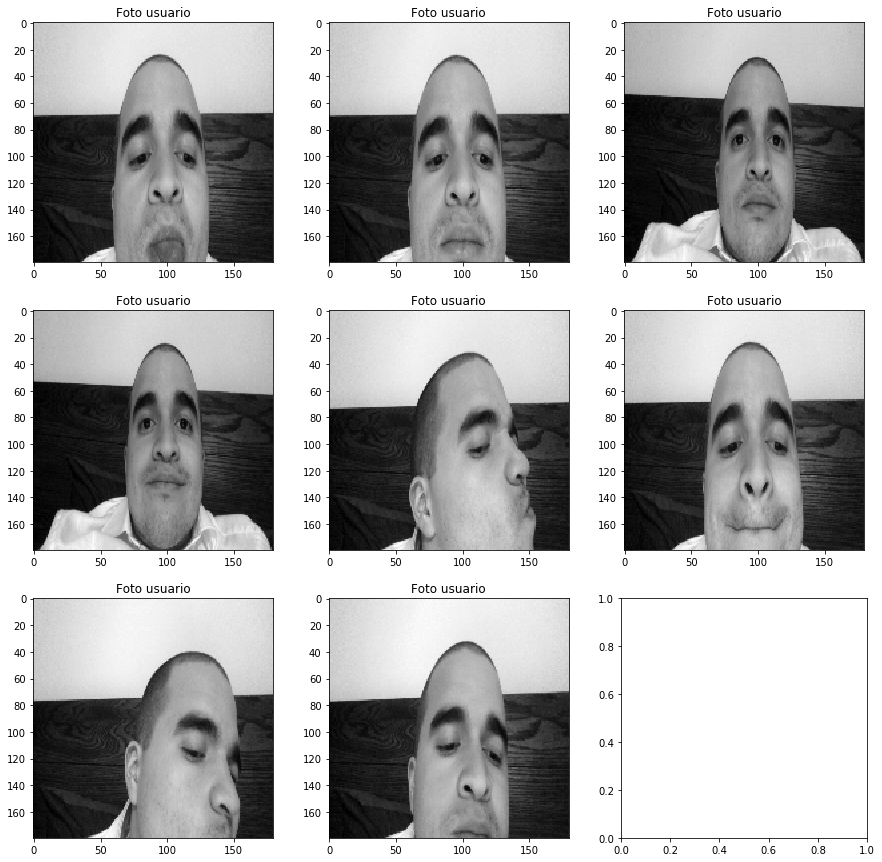

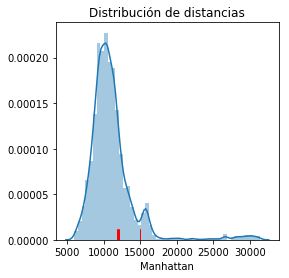

In [67]:
user_list = []
base1='user_photo/*'

for root1 in glob.glob(base1):
    user_list.append(root1)
    
data_set_user=np.zeros((len(user_list),180,180))


for image in range(len(user_list)):
     data_set_user[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(user_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)

if(distance_name.value=='Euclidean'):
    distances_user=np.linalg.norm(data_set_user-cero, ord=None, axis=(1,2), keepdims=False)
elif (distance_name.value=='Manhattan'):
    distances_user=np.linalg.norm(data_set_user-cero, ord=1, axis=(1,2), keepdims=False)
elif (distance_name.value=='Chess_board'):
    distances_user=np.linalg.norm(data_set_user-cero, ord=np.inf, axis=(1,2), keepdims=False)   
elif(distance_name.value=='DSSIM'):
    dssim=[]
    for image in range(data_set_user.shape[0]):
        sim=compare_ssim(cero,data_set_user[image,:,:])
        dis=(1-sim)/2
        dssim.append(dis)
    distances_user=np.array(dssim)

distances=all_distances[distance_name.value]
nf=len(user_list)

num_filas=int(nf/3-0.01)+1
plt.rcParams['figure.figsize'] = [5*num_filas,15]


fig, axs = plt.subplots(nrows=num_filas, ncols=3)

for i in range(nf):
    f=int(i/3)
    c=i%3
    if(num_filas>1):
        axs[f,c].imshow(data_set_user[i,:,:], cmap = plt.cm.gray) #check
        axs[f,c].set_title('Foto usuario')
    else:
        axs[i].imshow(data_set_user[i,:,:], cmap = plt.cm.gray) #check
        axs[i].set_title('Foto usuario')
        
plt.show();


plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(distances)
sns.rugplot(distances_user,color="r")
plt.title('Distribución de distancias')
plt.show();